In [171]:
# load libraries and scripts
include("../scripts/tools.jl")
include("../scripts/plotting.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl");
include("../scripts/ps_analysis.jl");

In [172]:
#load borders
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
Nx, Ny, coord, isinside, isborder, isgrid, n = get_grid(border, dx);

In [173]:
# compute or load grid parameters
minv, gamma, p, xi, bx, by, m, d = get_params_diff_fast(isinside, isgrid, n, Ny, Nx, Float64(dx), coord,
    scale_factor, "../data/disc/pantagruel.h5",
    "../numerics/grid_params_" * string(dx) * ".h5",
    Niter=20, dmax = 0.02, patch=3000.0, bmin=0.0, tau=0.00005);

  4.187211 seconds (1.28 M allocations: 16.889 GiB, 3.31% gc time, 15.28% compilation time)
  2.280485 seconds (6.70 k allocations: 1.897 GiB, 1.38% gc time)


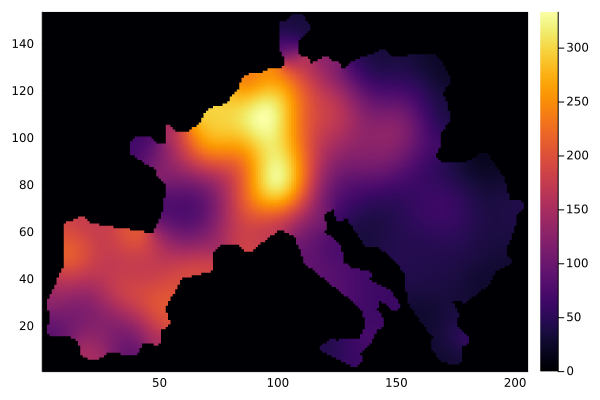

In [174]:
heatmap(reshape(bx,Ny,Nx))

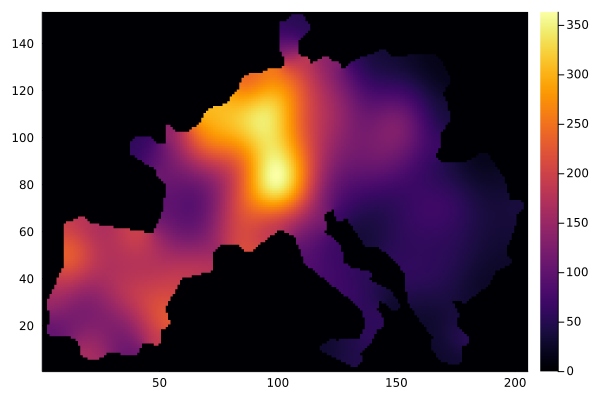

In [175]:
heatmap(reshape(by,Ny,Nx))

In [176]:
th0 = compute_stable_sol(isinside, n, bx, by, p, interval = 1000, Niter = 40000, tol = 1e-7);

[1000.0 0.0004440532741778469]
[2000.0 0.00021828800347523103]
[3000.0 0.00012039305396438493]
[4000.0 8.615315656529399e-5]
[5000.0 8.001597091805701e-5]
[6000.0 7.128965204006299e-5]
[7000.0 6.215899758721388e-5]
[8000.0 5.355264176865049e-5]
[9000.0 4.5811213283841745e-5]
[10000.0 3.9010896856872534e-5]
[11000.0 3.3114161627101346e-5]
[12000.0 2.8039155834602703e-5]
[13000.0 2.3691337561415615e-5]
[14000.0 1.997753156601778e-5]
[15000.0 1.6811767628022167e-5]
[16000.0 1.4117277148728569e-5]
[17000.0 1.1826720210161845e-5]
[18000.0 9.88163397197539e-6]
[19000.0 8.231578096262737e-6]
[20000.0 6.833203796796639e-6]
[21000.0 5.649351302983163e-6]
[22000.0 4.64822053081182e-6]
[23000.0 4.158791829161901e-6]
[24000.0 3.923650470333273e-6]
[25000.0 3.7027202343387078e-6]
[26000.0 3.4950088678986635e-6]
[27000.0 3.2996067042267985e-6]
[28000.0 3.1156794919606767e-6]
[29000.0 2.942461514277017e-6]
[30000.0 2.779249147683016e-6]
[31000.0 2.6253949335086624e-6]
[32000.0 2.4803021842767503e-6]


In [177]:
gen, dem, bline, idb, idgen, coord_disc, mg, dg, dl, th_ref = load_discrete_model("../data/disc/pantagruel.h5", scale_factor)
th = set_ref_phase(isgrid, coord[isgrid,:], th0, vec(coord_disc[1,:]), th_ref = 0.0)
th_disc = get_discrete_values(coord[isgrid,:], coord_disc, th[isgrid]);

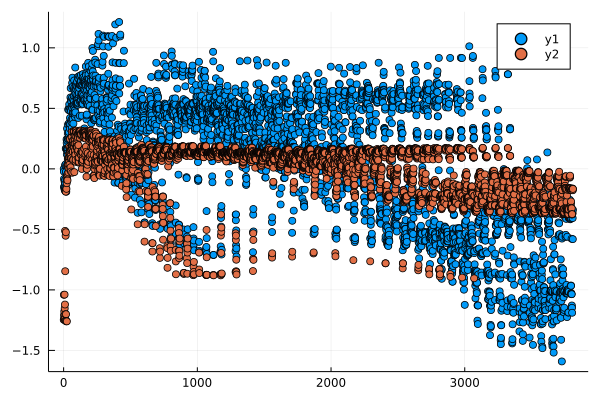

In [ ]:
scatter(th_ref)
scatter!(th_disc)

10-element Vector{Float64}:
  0.0
 -0.0226803185
 -0.08255987999999999
 -0.1512361005
 -0.14479086154164503
 -0.16422591899620115
 -0.10294962525995835
 -0.145948045541645
 -0.17782344012990436
 -0.11313045793952638

In [85]:
sum(bline) / length(bline)

173.53447759531596